In [9]:
# Generic
from pathlib import Path
import typing

# Numerical Computing
import numpy as np
import torch
from jaxtyping import Float, Int, Bool
import matplotlib.pyplot as plt

from muutils.misc import shorten_numerical_to_str, sanitize_fname
from muutils.nbutils.configure_notebook import configure_notebook

# Our Code
# dataset stuff
from maze_dataset import MazeDataset, MazeDatasetConfig, SolvedMaze, LatticeMaze, SPECIAL_TOKENS, LatticeMazeGenerators
from maze_dataset.plotting import MazePlot, PathFormat
from maze_dataset.tokenization import MazeTokenizer, TokenizationMode
from maze_dataset.plotting.print_tokens import color_maze_tokens_AOTP

# model stuff
from maze_transformer.training.config import ZanjHookedTransformer

# mechinterp stuff
from maze_transformer.mechinterp.logit_attrib_task import LOGIT_ATTRIB_TASKS
from maze_transformer.evaluation.load_model_testdata import load_model_with_test_data
from maze_transformer.evaluation.eval_single_token_tasks import TaskPrompts, TaskEvalResult, get_task_prompts_targets, eval_model_across_tasks, plot_task_accuracy
from maze_transformer.evaluation.plotting import plot_predicted_paths
from maze_transformer.mechinterp.plot_logits import get_baseline_incorrect_group, plot_logit_histograms
from maze_transformer.evaluation.baseline_models import RandomBaseline



In [2]:
# Setup (we won't be training any models)
DEVICE: torch.device = configure_notebook(seed=42, dark_mode=False)
print(f"{DEVICE = }")
torch.set_grad_enabled(False)


DEVICE = device(type='cuda')


In [31]:

MODELS_PATHS: list[str] = [
	"../examples/model.hallway-insto.v17.zanj",
	"../examples/model.hallway-insto.final.zanj",
	"../examples/wandb.jerpkipj.zanj",
]

DATASET_CFG_SOURCE: MazeDatasetConfig = MazeDatasetConfig(
	name="hallway",
	grid_n=6,
	n_mazes=100,
	maze_ctor=LatticeMazeGenerators.gen_dfs,
	maze_ctor_kwargs=dict(do_forks=False),
)

In [43]:

def all_plots(
	model_path: str,
	dataset_cfg_source: MazeDatasetConfig,
	plot_dir: Path|str = "plots/",
) -> None:
	model, dataset = load_model_with_test_data(
		model_path=model_path,
		dataset_cfg_source=dataset_cfg_source,
		n_examples=500,
	)

	title_suffix: str = f"model: {model.config.name}\ndataset: {dataset.cfg.to_fname()}"
	file_id: str = sanitize_fname(f"{model.config.name}.{dataset.cfg.to_fname()}")
	plot_dir = Path(plot_dir) / file_id
	plot_dir.mkdir(parents=True, exist_ok=True)

	# rollouts
	fig, ax = plot_predicted_paths(
		model=model,
		dataset=dataset,
		n_mazes=20, 
		max_new_tokens=50, 
		row_length=5, 
		figsize_scale=5,
		predicted_path_fmt=PathFormat(cmap="winter"),
		show=False,
	)

	fig.suptitle(f"Predicted Paths\n{title_suffix}", fontsize=20)
	# make the figure taller
	fig.set_figheight(fig.get_figheight() + 1)
	fig.savefig(plot_dir / "rollouts.pdf", bbox_inches="tight")
	plt.show()

	# task accuracy
	tokenizer: MazeTokenizer = model.zanj_model_config.maze_tokenizer
	task_prompts_targets: TaskPrompts = get_task_prompts_targets(
		dataset=dataset,
		maze_tokenizer=tokenizer,
		tasks=LOGIT_ATTRIB_TASKS,
	)

	task_results: dict[str, TaskEvalResult] = eval_model_across_tasks(
		model = model,
		task_prompts = task_prompts_targets,
	)

	fig, ax = plot_task_accuracy(task_results)
	fig.suptitle(f"Prediction accuracy across tasks\n{title_suffix}")
	fig.set_figheight(fig.get_figheight() + 1)
	fig.savefig(plot_dir / "task_accuracy.pdf", bbox_inches="tight")
	
	baseline: RandomBaseline = RandomBaseline(model.config)

	histograms_plot_dir: Path = plot_dir / f"logit_histograms"
	histograms_plot_dir.mkdir(parents=True, exist_ok=True)

	for task_name, task_result in task_results.items():

		# skip the path_start task since baseline model wont do it
		if task_name == "path_start":
			continue

		prompts: list[list[str]]; targets: list[str]
		prompts, targets = task_prompts_targets[task_name]

		incorrect_but_valid: Bool[torch.Tensor, "n_mazes d_vocab"] = get_baseline_incorrect_group(
			prompts=prompts,
			tokenizer=tokenizer,
			baseline=baseline,
		)

		ax_logit_hist = plot_logit_histograms(
			last_tok_logits=task_result.last_tok_logits,
			target_idxs=torch.tensor(tokenizer.encode(targets)),
			token_groups={
				"grid adjacent but incorrect": incorrect_but_valid,
			},
			show_all_other_tokens=True,
			n_bins=50,
			density=False,
			logy=True,
		)
		ax_logit_hist.set_title(f"Logit Histograms for '{task_name}' task\n{title_suffix}")

		fig_logit_hist = ax_logit_hist.get_figure()
		fig_logit_hist.savefig(histograms_plot_dir / f"{task_name}.pdf", bbox_inches="tight")




loaded model with 1.2M params (num_params = 1234735) from
../examples/model.hallway-insto.v17.zanj
original model name: 'model.zanj_model_config.name = 'hallway-medium'', changing to 'hallway-insto.v17'
loaded dataset with 500 examples
dataset.cfg.summary() = {'name': 'hallway', 'fname': 'hallway-g6-n500-a_dfs-h70565', 'sdc_hash': 111660789125064395993781216668390008244105588589492098645670286953669870770565, 'seed': 42, 'seq_len_min': 1, 'seq_len_max': 512, 'applied_filters': [], 'grid_n': 6, 'grid_shape': (6, 6), 'n_mazes': 500, 'maze_ctor_name': 'gen_dfs', 'maze_ctor_kwargs': {'do_forks': False}}


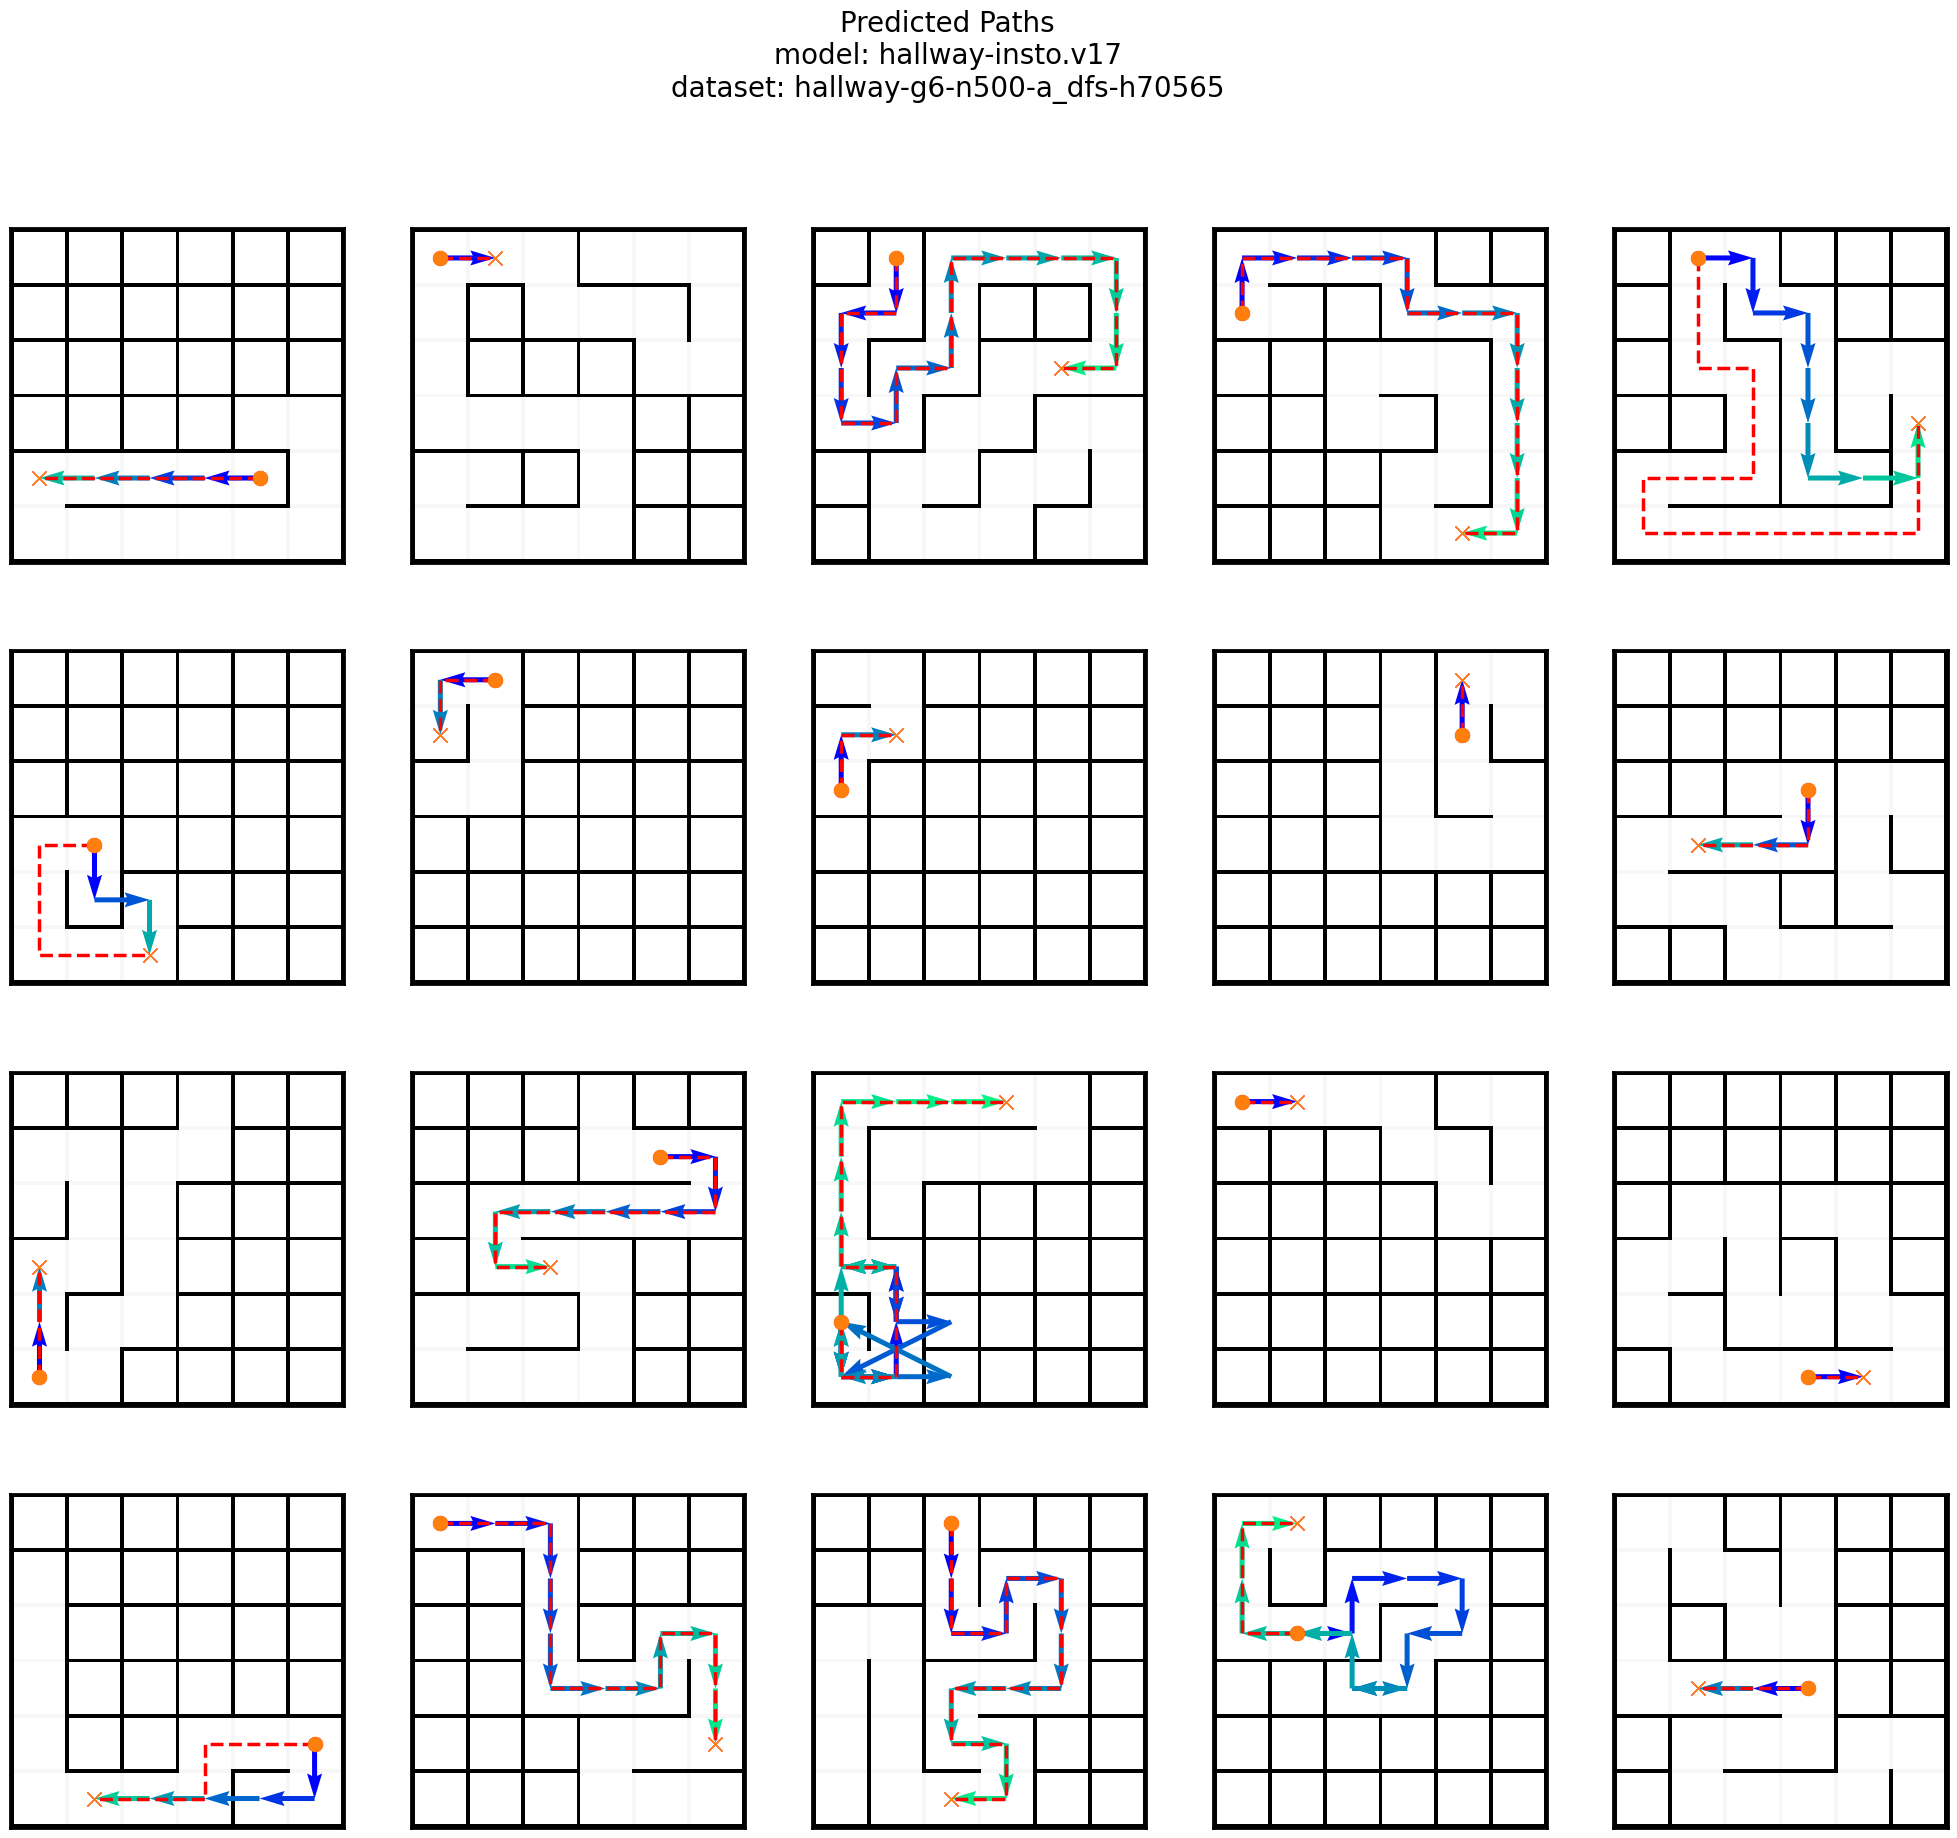

running task path_start
running task origin_after_path_start
running task first_path_choice
running task path_end
running task final_before_path_end
running task rand_path_token
running task rand_path_token_non_endpoint
acc_means = {'path_start': 1.0, 'origin_after_path_start': 0.9980000257492065, 'first_path_choice': 0.7559999823570251, 'path_end': 0.984000027179718, 'final_before_path_end': 0.972000002861023, 'rand_path_token': 0.9399999976158142, 'rand_path_token_non_endpoint': 0.984000027179718}
loaded model with 1.2M params (num_params = 1234735) from
../examples/model.hallway-insto.final.zanj
original model name: 'model.zanj_model_config.name = 'hallway-medium'', changing to 'hallway-insto.final'
loaded dataset with 500 examples
dataset.cfg.summary() = {'name': 'hallway', 'fname': 'hallway-g6-n500-a_dfs-h70565', 'sdc_hash': 111660789125064395993781216668390008244105588589492098645670286953669870770565, 'seed': 42, 'seq_len_min': 1, 'seq_len_max': 512, 'applied_filters': [], 'grid

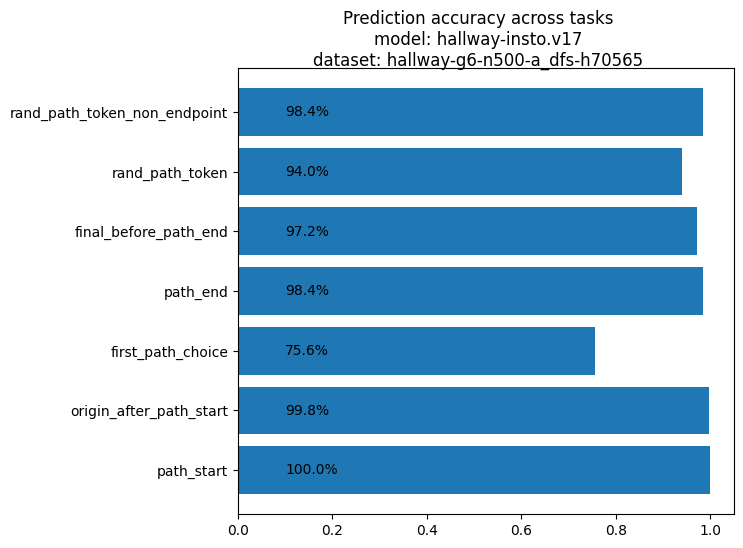

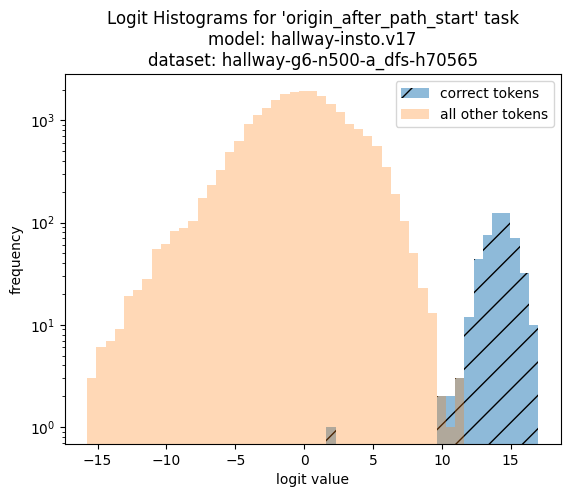

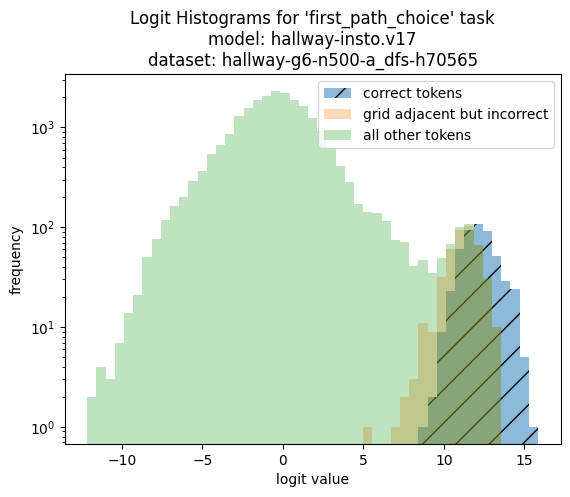

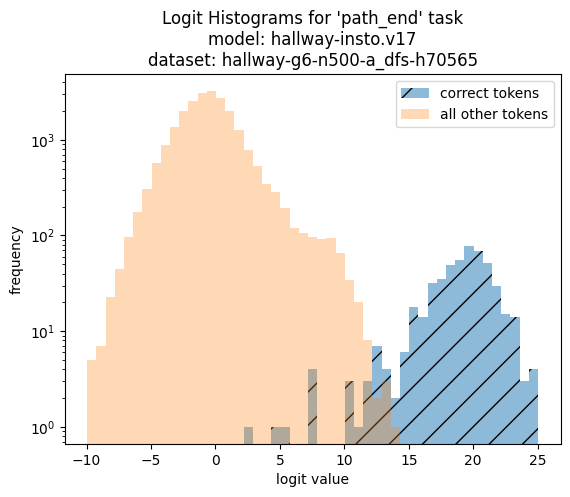

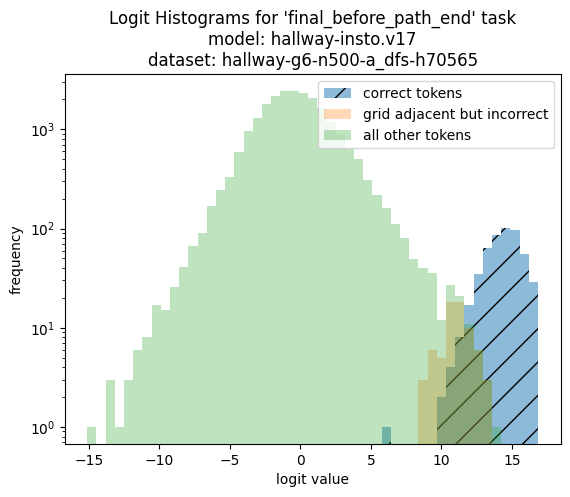

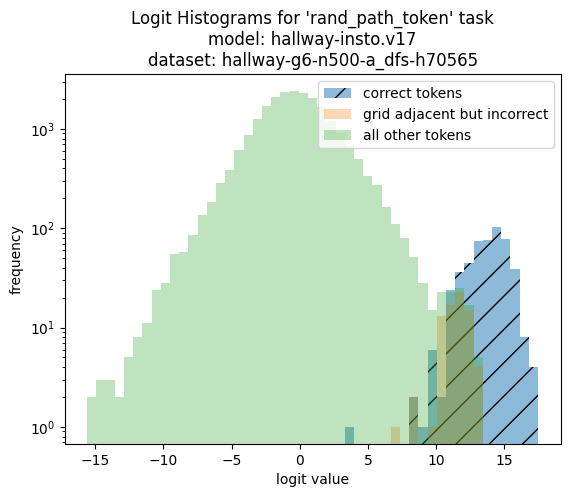

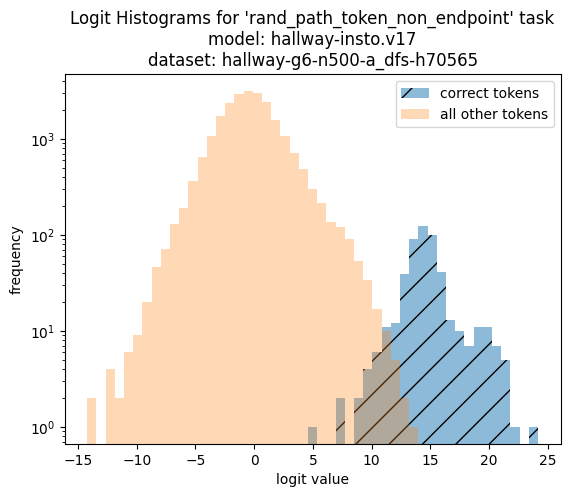

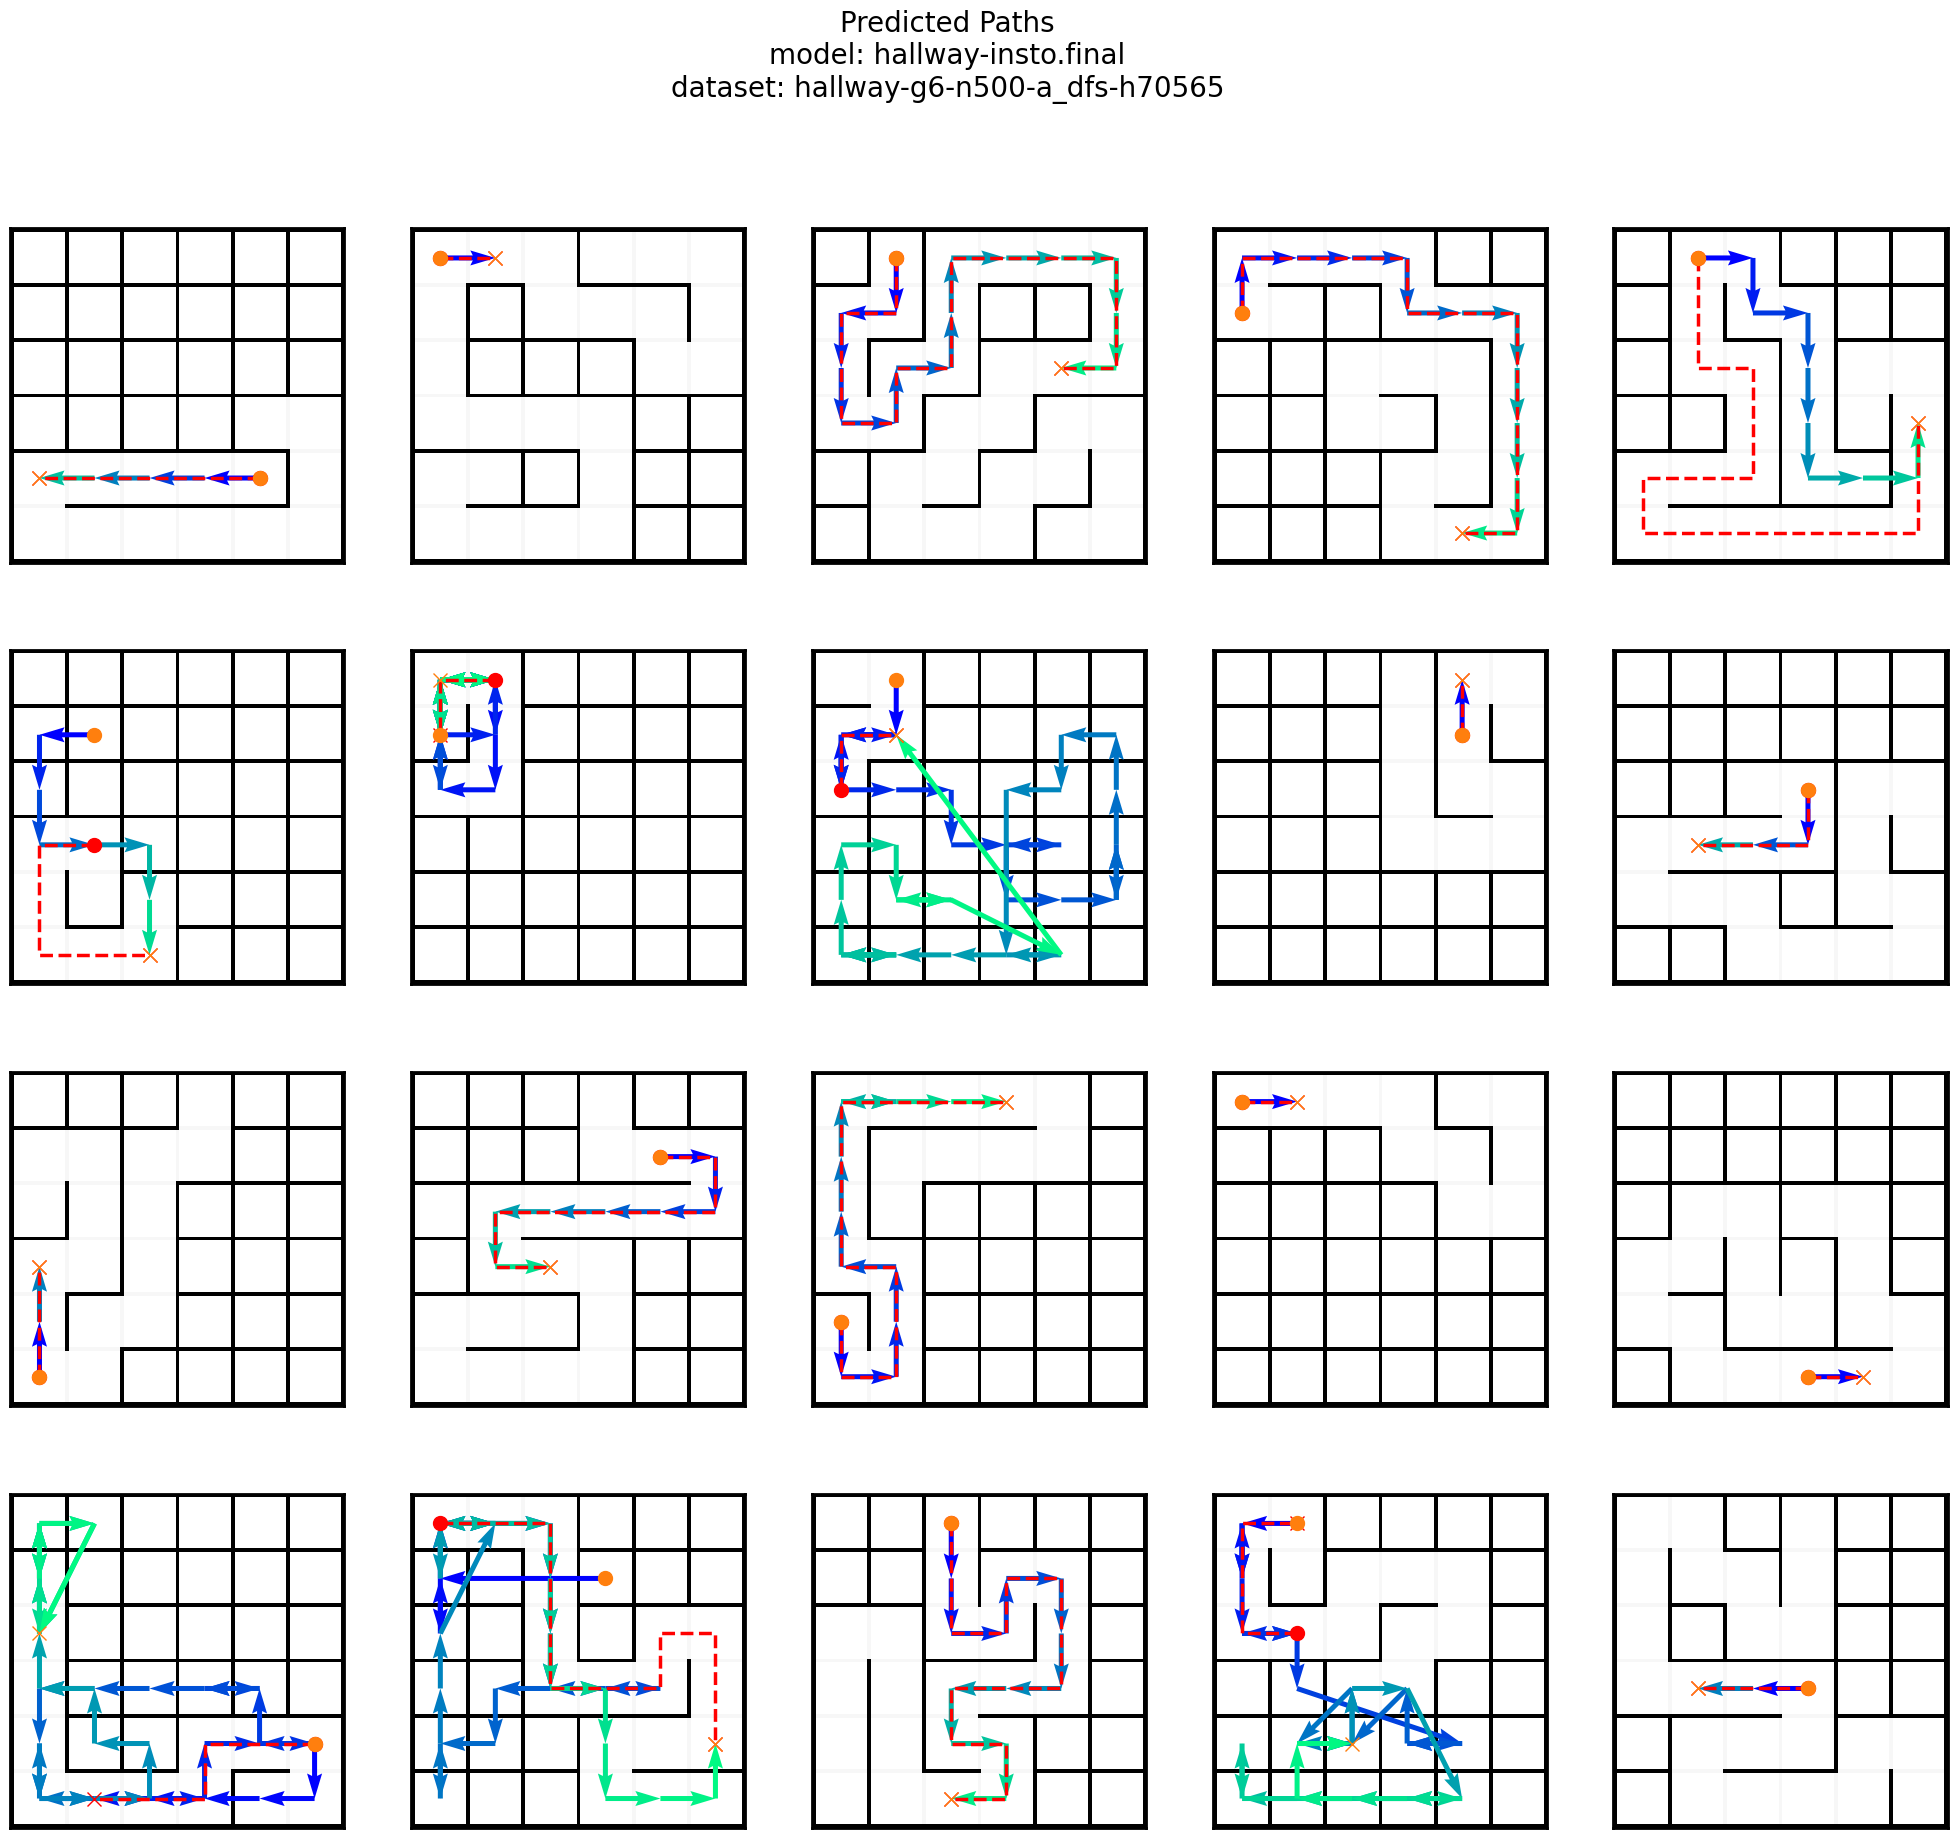

running task path_start
running task origin_after_path_start
running task first_path_choice
running task path_end
running task final_before_path_end
running task rand_path_token
running task rand_path_token_non_endpoint
acc_means = {'path_start': 1.0, 'origin_after_path_start': 0.828000009059906, 'first_path_choice': 0.699999988079071, 'path_end': 0.8619999885559082, 'final_before_path_end': 0.9480000138282776, 'rand_path_token': 0.8519999980926514, 'rand_path_token_non_endpoint': 0.9440000057220459}
loaded model with 9.6M params (num_params = 9639484) from
../examples/wandb.jerpkipj.zanj
original model name: 'model.zanj_model_config.name = 'default'', changing to 'jerpkipj'
loaded dataset with 500 examples
dataset.cfg.summary() = {'name': 'hallway', 'fname': 'hallway-g6-n500-a_dfs-h70565', 'sdc_hash': 111660789125064395993781216668390008244105588589492098645670286953669870770565, 'seed': 42, 'seq_len_min': 1, 'seq_len_max': 512, 'applied_filters': [], 'grid_n': 6, 'grid_shape': (6, 6)

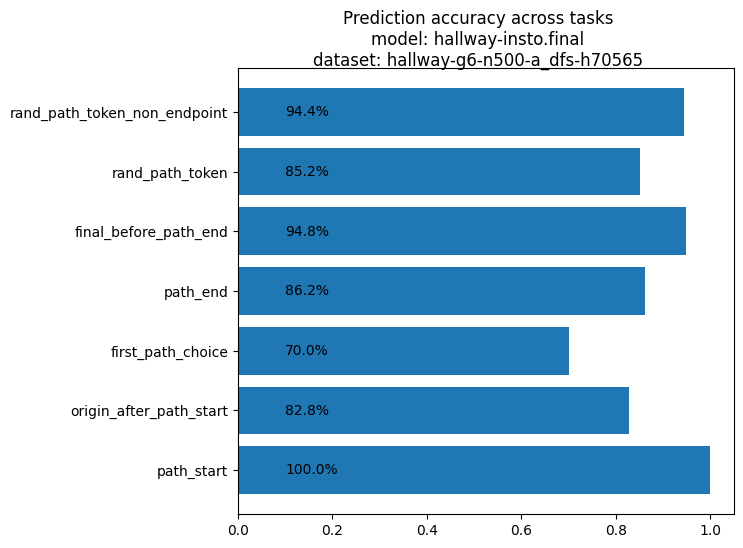

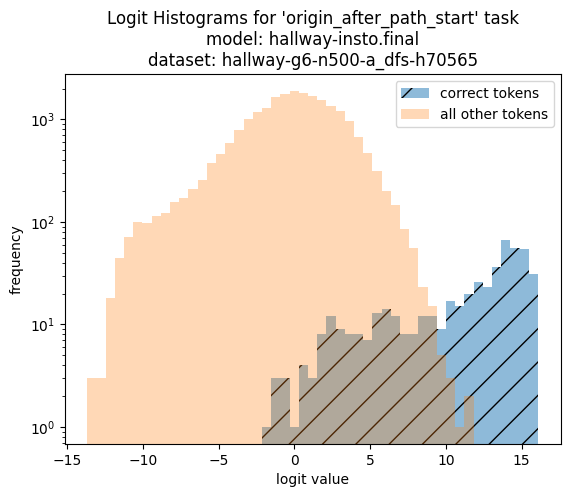

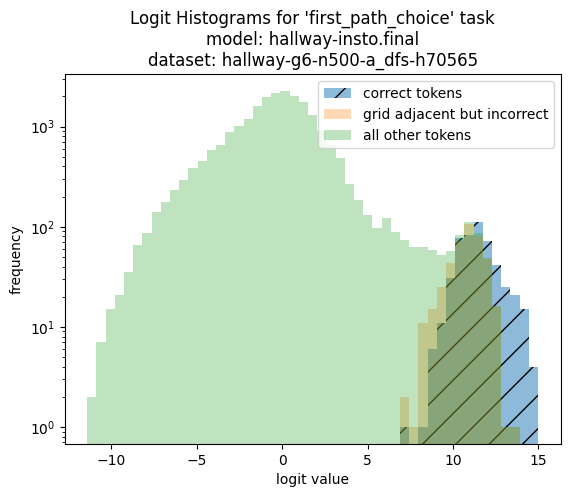

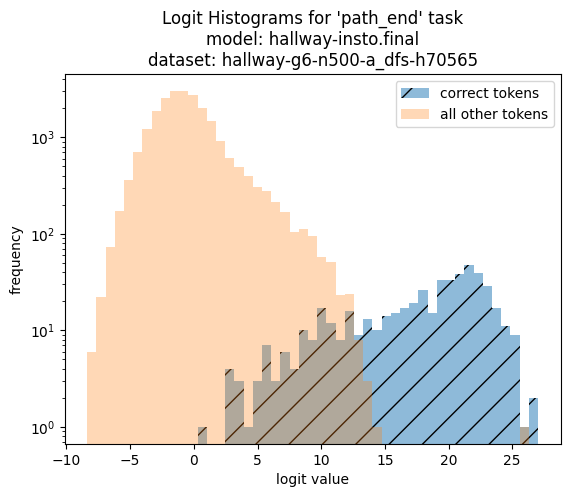

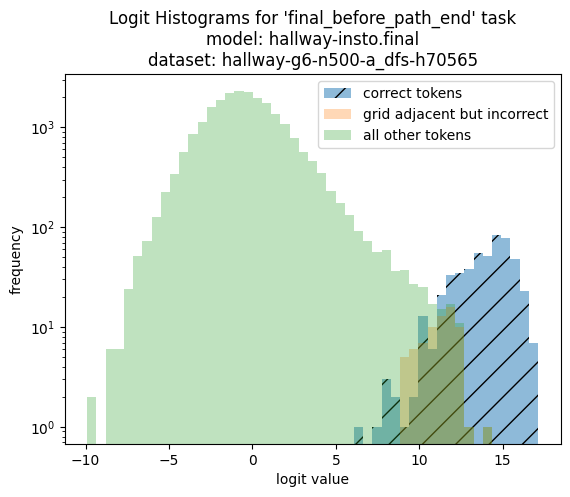

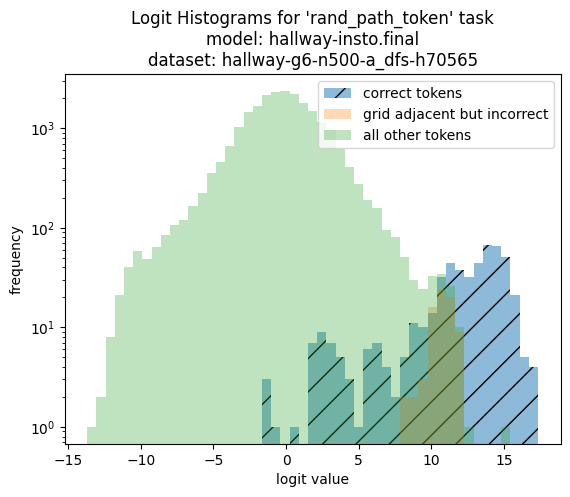

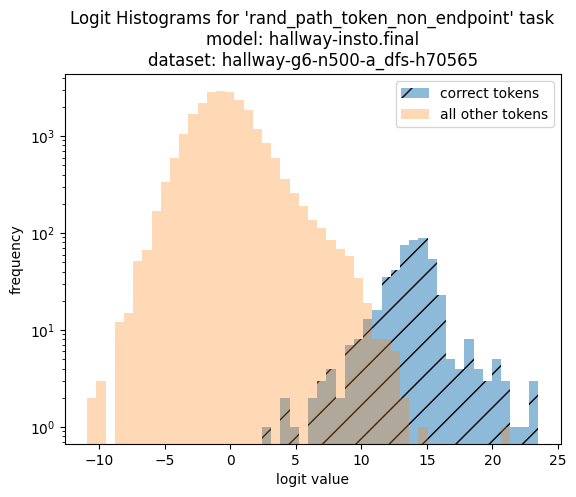

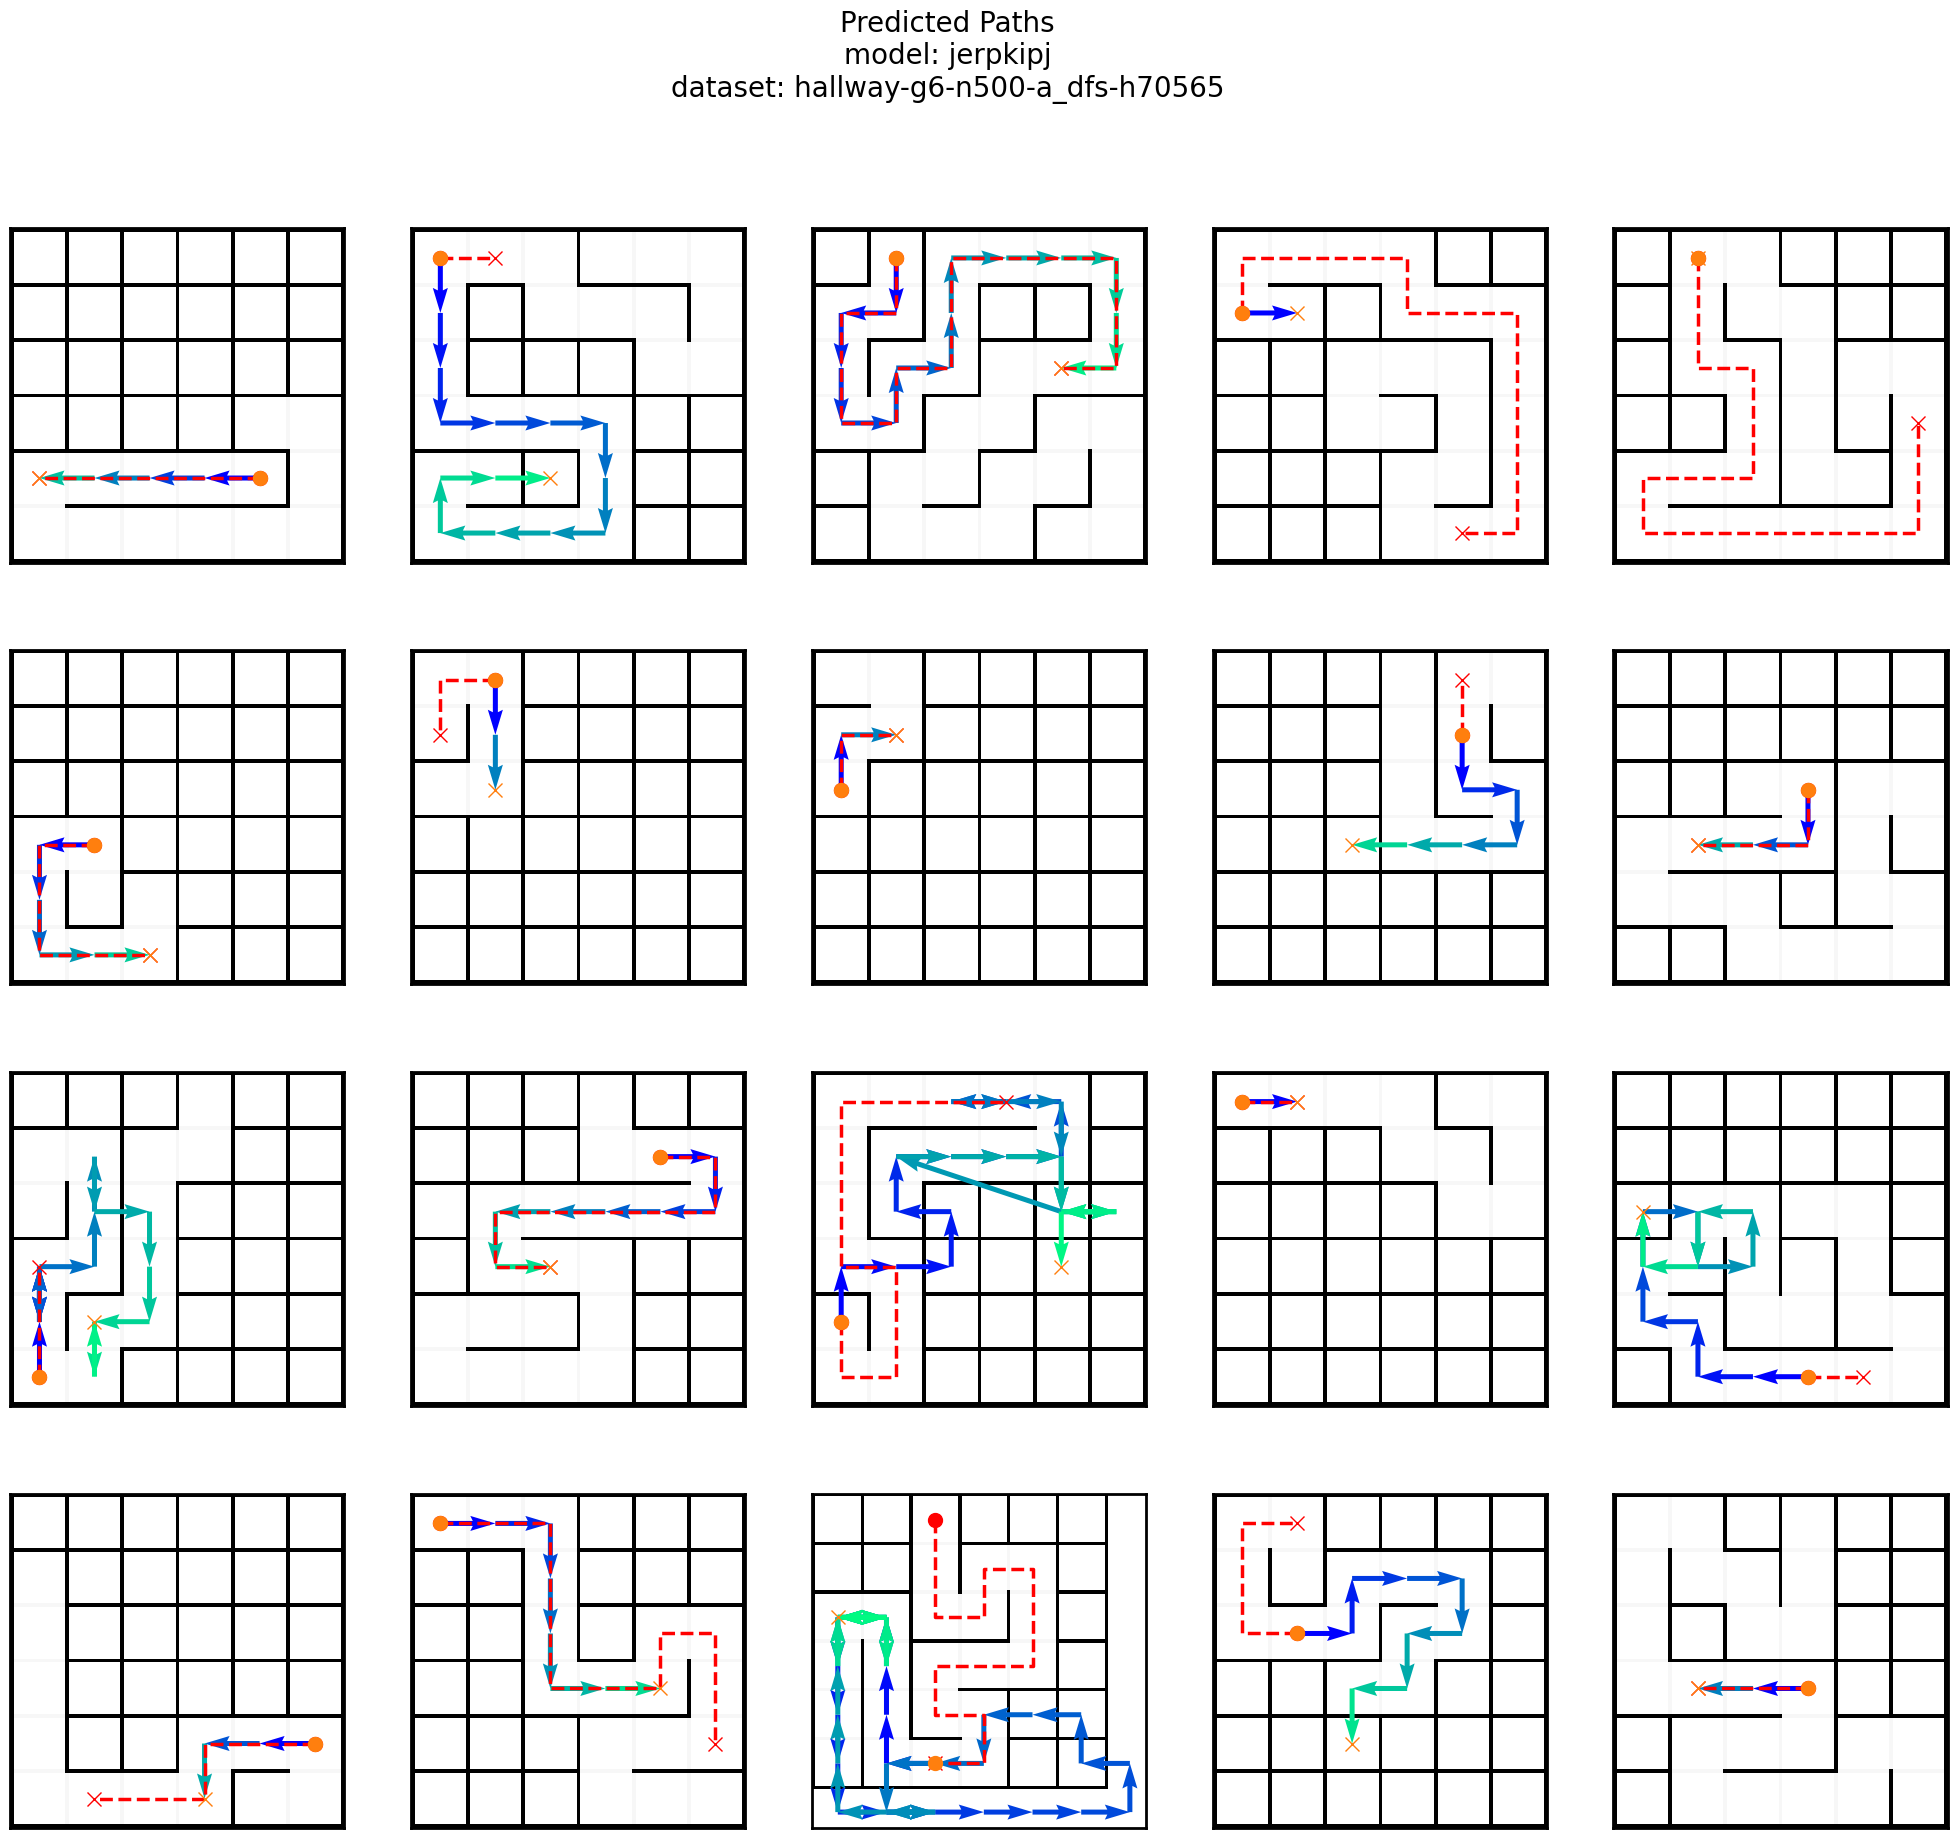

running task path_start
running task origin_after_path_start
running task first_path_choice
running task path_end
running task final_before_path_end
running task rand_path_token
running task rand_path_token_non_endpoint
acc_means = {'path_start': 1.0, 'origin_after_path_start': 0.8579999804496765, 'first_path_choice': 0.6600000262260437, 'path_end': 0.6980000138282776, 'final_before_path_end': 0.843999981880188, 'rand_path_token': 0.8320000171661377, 'rand_path_token_non_endpoint': 0.878000020980835}


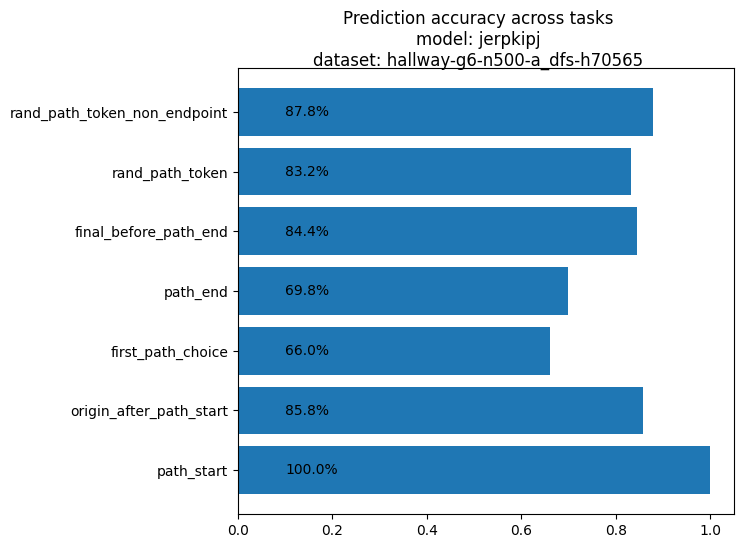

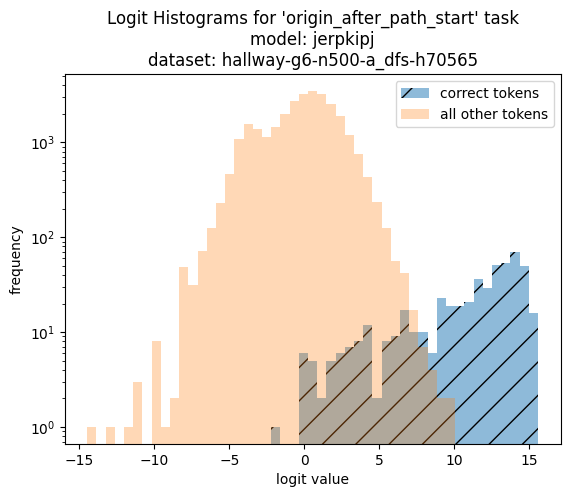

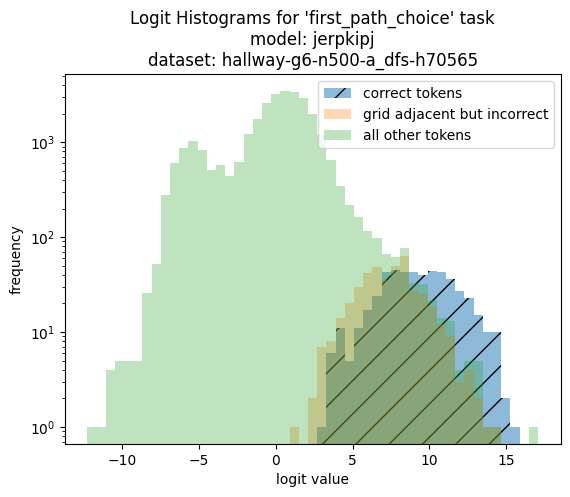

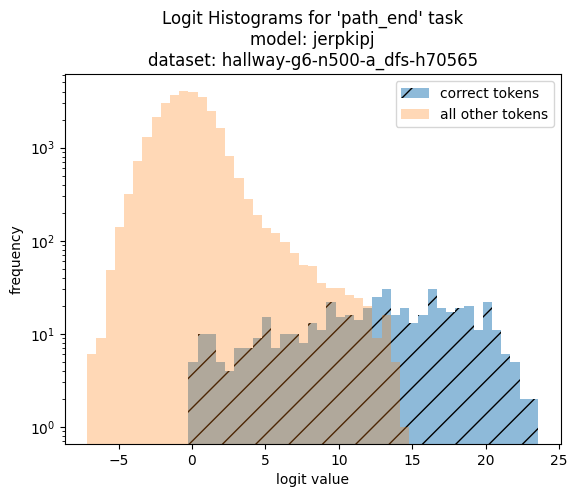

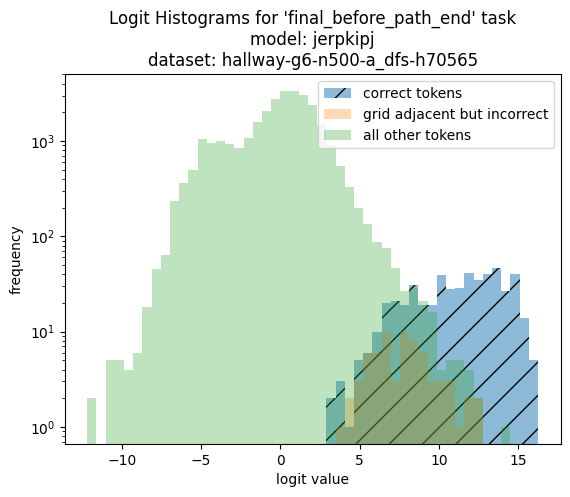

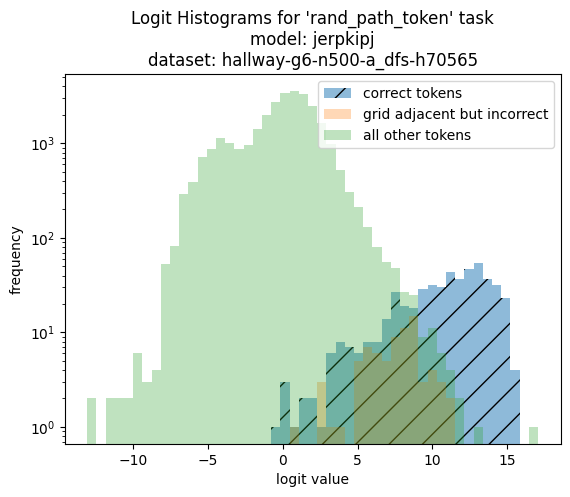

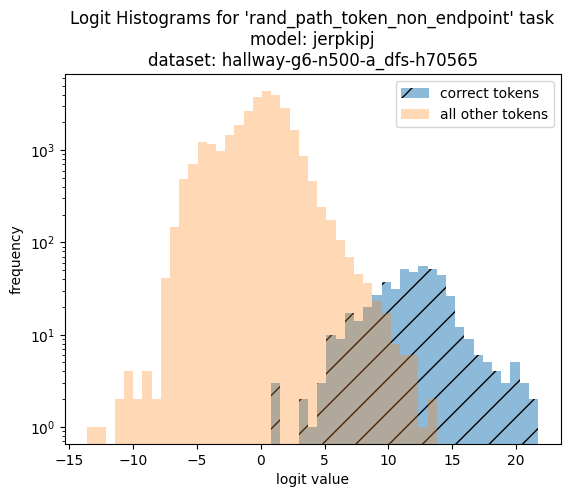

In [44]:
for model_path in MODELS_PATHS:
	all_plots(
		model_path, 
		DATASET_CFG_SOURCE,
	)